In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import os
import math
from collections import defaultdict

In [5]:
sns.set()
sns.set_palette('pastel')

## Helpers

In [6]:
def rssi2meters(rssi, tx=-59, N=2):
  return 10 ** (-(rssi - tx) / (10 * N))

In [7]:
def meters2rssi(meters, tx=-59, N=2):
    return -10 * N * math.log10(meters) + tx

In [8]:
class KalmanFilter:
    def __init__(self, process_noise=0.1, sensor_noise=3.5, estimated_error=0, value=None):
        self.process_noise = process_noise
        self.sensor_noise = sensor_noise
        self.estimated_error = estimated_error
        self.prediction_cycles = 0
        self.value = value
        
    def get_filtered_value(self, measurement):
        if measurement is None or np.isnan(measurement):
            return measurement
        # prediction phase
        self.estimated_error += self.process_noise
        
        if self.value is None:
            self.value = measurement
        
        # measurement update
        kalman_gain = self.estimated_error / (self.estimated_error + self.sensor_noise)
        self.value = self.value + kalman_gain * (measurement - self.value)
        self.estimated_error = (1 - kalman_gain) * self.estimated_error
        
        return self.value

In [9]:
def find_area(areas, x, y):
    """
    Returns the index of the area containing (x, y), or None if not found.
    """
    for idx, (x0, y0, x1, y1) in enumerate(areas):
        if x0 <= x <= x1 and y0 <= y <= y1:
            return idx
    return None

In [10]:
palette = sns.color_palette('pastel', n_colors=6)

In [11]:
beacons = np.array([
    (26.681, 0.252),
    (25.608, 9.221),
    (11.209, 9.197),
    (0,0),
    (35.417, 7.612),
    (2.7, 9.812),
])
ST = (35.417, 9.812)

In [12]:
theorical_positions = [
    (16.179, 8.217),      # L0N
    (33.047, 4.906),  # L1N
    (28.608, 4.906),  # L2N
    (23.678, 4.906), # L3N
    (17.179, 2.16),  # L4N
    (9.259, 4.906),      # L5N
    (3.72, 7.197),     # L6
    (16.179, 8.217),      # L0
]

areas = [
    (11.809, 4.906, 21.338, 9.812), # Area 0
    (30.877, 0, 35.417, 9.812),     # Area 1
    (21.338, 0, 30.877, 9.812),     # Area 2
    (21.338, 0, 30.877, 9.812),     # Area 2
    (11.809, 0, 21.338, 4.906),     # Area 3
    (0, 4.312, 11.809, 9.812),      # Area 4
    (0, 4.312, 11.809, 9.812),      # Area 4
]

## Raw Analysis

In [13]:
data_dir = 'data/exp-walking-museum'

In [14]:
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

In [15]:
dfs = [
    pd.read_csv(os.path.join(data_dir, csv), parse_dates=['time']).assign(dataset_index=i + 1)
    for i, csv in enumerate(csv_files)
    #if '14T15' in csv 
]
size = len(dfs)
size

3

In [16]:
df = pd.concat(dfs)
df = df[['xp_step', 'x', 'y', 'ESP32-1_rssi', 'ESP32-2_rssi', 'ESP32-3_rssi', 'ESP32-4_rssi', 'ESP32-5_rssi', 'ESP32-6_rssi']][(df['xp_step'] <= 14) & (df['xp_step'] >= 0) & (df['xp_step'] % 2 == 0)]
df['xp_step'] //=2
df['tx'] = [theorical_positions[int(row['xp_step'])][0] for i, row in df.iterrows()]
df['ty'] = [theorical_positions[int(row['xp_step'])][1] for i, row in df.iterrows()]
df['dx'] = (df['x']-df['tx']).abs()
df['dy'] = (df['y']-df['ty']).abs()
df['d'] = ((df['x']-df['tx'])**2 + (df['y']-df['ty'])**2)**0.5
df['area'] = [find_area(areas, row['x'], row['y']) for i, row in df.iterrows()]
df['tarea'] = [find_area(areas, row['tx'], row['ty']) for i, row in df.iterrows()]
df['carea'] = df['area'] == df['tarea']
for i in range(1, 7):
    df[f'ESP32-{i}_rssi'] = np.isfinite(df[f'ESP32-{i}_rssi'])

In [17]:
fdfb = fdf = df[((df['x'] != 0) | (df['y'] != 0)) & (df['xp_step'] >= 0)]
fdf = df[((df['x'] != 0) | (df['y'] != 0)) & (df['xp_step'] > 0)]

In [18]:
p50, p75, p90 = np.quantile(fdf['d'], [0.5, 0.75, 0.90])
print(f'{p50=:.3}, {p75=:.3}, {p90=:.3}')

p50=2.8, p75=3.86, p90=5.81


In [19]:
failed_rate = len(df[(df['x'] == 0) & (df['y'] == 0)])/len(df)
print(f'Unkown location for {failed_rate:.2%} of the data')

Unkown location for 9.04% of the data


In [20]:
fdf.groupby('xp_step').median()['d']

xp_step
1    2.960944
2    1.532886
3    2.841888
4    2.909956
5    3.215342
6    2.431291
7    5.981920
Name: d, dtype: float64

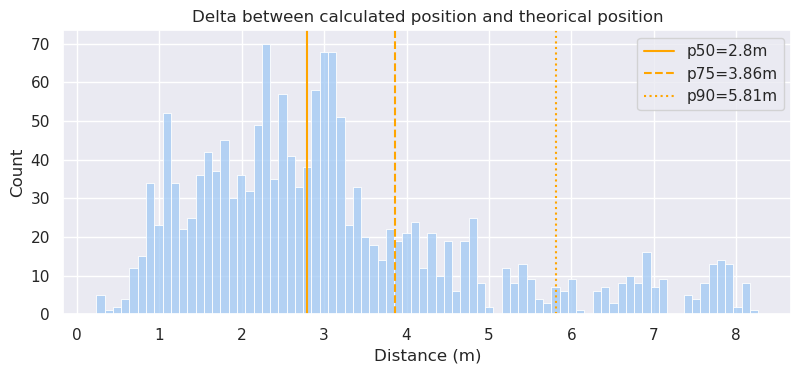

In [32]:
plt.figure(figsize=(8, 4))
plt.subplots_adjust(bottom=0.13, top=0.84, left=0.07, right=0.98)

sns.histplot(data=fdf, x='d', binwidth=0.1)
plt.axvline(x=p50, color='orange', label=f'{p50=:.3}m')
plt.axvline(x=p75, color='orange', ls='--', label=f'{p75=:.3}m')
plt.axvline(x=p90, color='orange', ls='dotted', label=f'{p90=:.3}m')

plt.title('Delta between calculated position and theorical position')
plt.xlabel('Distance (m)', x=0.5, y=-0.1)
plt.legend()

plt.savefig('out/museum-location-precision.pdf')

In [23]:
precision = (fdfb.groupby('xp_step').mean()['carea'] * [0.5/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0.5/7]).sum()

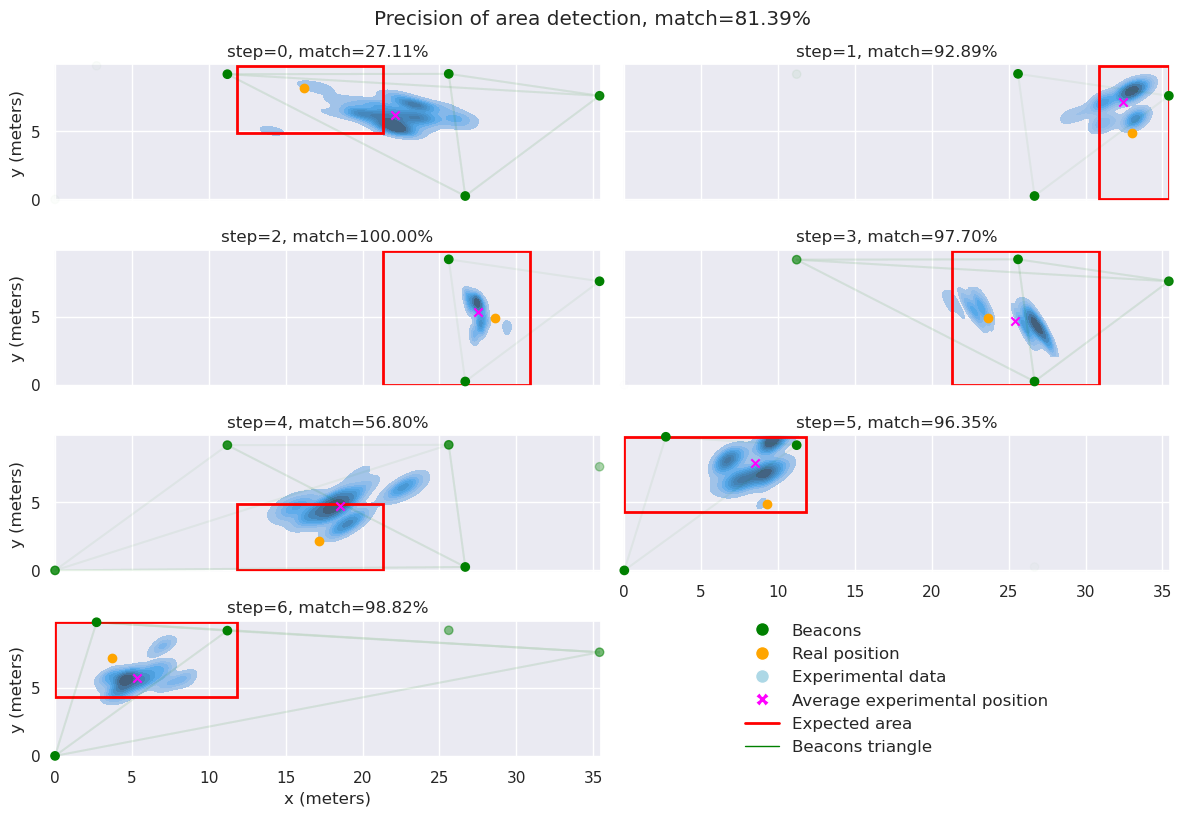

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(12, 12/ST[0]*ST[1]*2.5), sharex=True, sharey=True)

axes = axes.flatten()  # Make axes iterable as a flat array

for i in range(0, 7):  # i from 1 to 7
    sdf = fdfb[(fdfb['xp_step'] == i) | (fdfb['xp_step'] == i+7)]
    pbeacons = [sdf[f'ESP32-{i}_rssi'].mean() for i in range(1, 7)]
    ax = axes[i]
    ax.set_xlim((-0.1, ST[0]+0.1))
    ax.set_ylim((-0.1, ST[1]+0.1))
    sns.kdeplot(
        data=sdf, x="x", y="y", fill=True, ax=ax
    )
    ax.scatter(*theorical_positions[i], color='orange')
    ax.set_title(f"step={i}, match={sdf['carea'].mean():.2%}")
    ax.set_xlabel('x (meters)')
    ax.set_ylabel('y (meters)')

    x0, y0, x1, y1 = areas[i]
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, 
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    ax.scatter(*beacons.T, alpha=pbeacons, color='green', clip_on=False, zorder=100)
    
    ax.scatter(sdf['x'].mean(), sdf['y'].mean(), marker='x', color='magenta')
                
    for j in range(0, 4):
        b1x, b1y = beacons[j]
        for k in range(j+1, 5):
            b2x, b2y = beacons[k]
            for l in range(k+1, 6):
                b3x, b3y = beacons[l]
                p = len(sdf[(sdf[f'ESP32-{j+1}_rssi']) & (sdf[f'ESP32-{k+1}_rssi']) & (sdf[f'ESP32-{l+1}_rssi'])]) / len(sdf)
                if p > 0.5:
                    ax.plot([b1x, b2x, b3x, b1x], [b1y, b2y, b3y, b1y], alpha=0.05, color='green')

axes[7].axis("off")
axes[5].tick_params(axis='x', labelbottom=True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Beacons', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Real position', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Experimental data', markerfacecolor='lightblue', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Average experimental position', markerfacecolor='magenta', markersize=10),
    Line2D([0], [0], marker=None, color='red', lw=2, label='Expected area'),
    Line2D([0], [0], marker=None, color='green', lw=1, label='Beacons triangle'),
]

axes[7].legend(handles=legend_elements, loc='center', frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(f'Precision of area detection, match={precision:.2%}')

plt.savefig('out/museum-area-precision.pdf')